# Generating Text with an RNN

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
HOME_DIR = os.getcwd()
PWD = os.path.join(HOME_DIR, 'gdrive', 'MyDrive', 'Colab Notebooks', 'CS498', 'assignment4_materials')
print(PWD)
os.chdir(PWD)
# print(HOME_DIR)

/content/gdrive/MyDrive/Colab Notebooks/CS498/assignment4_materials


In [ ]:
# Download celeb data
!chmod u+rwx download_language.sh
!./download_language.sh

--2021-04-21 18:17:34--  https://raw.githubusercontent.com/Junting98/language_data/master/language_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25976656 (25M) [application/zip]
Saving to: ‘language_data.zip.1’

language_data.zip.1 100%[===================>]  24.77M  63.5MB/s    in 0.4s    

2021-04-21 18:17:36 (63.5 MB/s) - ‘language_data.zip.1’ saved [25976656/25976656]



In [3]:
# move the zip file to Kontent and unpack
if True:
  import shutil 
  shutil.copyfile("language_data.zip", "/content/language_data.zip")
  os.makedirs('/content/language_data', exist_ok=True)
  !unzip "language_data.zip" -d "/content/language_data"

Archive:  language_data.zip
   creating: /content/language_data/language_data/
  inflating: /content/language_data/__MACOSX/._language_data  
  inflating: /content/language_data/language_data/.DS_Store  
  inflating: /content/language_data/__MACOSX/language_data/._.DS_Store  
   creating: /content/language_data/language_data/test/
  inflating: /content/language_data/__MACOSX/language_data/._test  
  inflating: /content/language_data/language_data/kaggle_rnn_language_classification_test.txt  
  inflating: /content/language_data/__MACOSX/language_data/._kaggle_rnn_language_classification_test.txt  
   creating: /content/language_data/language_data/train/
  inflating: /content/language_data/__MACOSX/language_data/._train  
  inflating: /content/language_data/language_data/shakespeare.txt  
  inflating: /content/language_data/__MACOSX/language_data/._shakespeare.txt  
  inflating: /content/language_data/language_data/test/portuguese_test.txt  
  inflating: /content/language_data/__MACOSX/l

In [4]:
!pip install unidecode
# os.listdir("/content/language_data/language_data")

     |████████████████████████████████| 245kB 4.3MB/s 


In [5]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 1

%aimport rnn.model

In [6]:
from rnn.helpers import time_since
from rnn.generate import generate

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [8]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = '/content/language_data/language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [9]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

less us and the land withal,
Yet to draw forth your noble ancestry
From the corruption of abusing times,
Unto a lineal true-derived course.

Lord Mayor:
Do, good my lord, your citizens entreat you.

BU


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [10]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [11]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [12]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [ ]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50

In [13]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [ ]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    rnn.train()
    optimizer.zero_grad()
    loss = 0.0

    batch_size = target.size()[0]
    chunk_len = target.size()[1]
    hidden = rnn.init_hidden(batch_size = batch_size, device = input.device)

    ####################################
    #          YOUR CODE HERE          #
    ####################################

    # from eval_test
    for c in range(chunk_len):
        output, hidden = rnn(input[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss = loss / chunk_len
    loss.backward()
    optimizer.step()
    ##########       END      ##########

    # for consistency with eval_test
    return loss.data.item()

## Training
We do the training here. For brevity the code + output text is skipped, please see the notebook attached for these details. Here we focus only on the loss plots.

In [ ]:
from rnn.model import RNN

In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 28s (50 1%) train loss: 2.0697, test_loss: 2.0946]
Whith ren the romed, repere the me my thoust is drime mace a wous
The storg ardend?

DUCHANDICMARUS:
A 

 58s (100 2%) train loss: 1.8749, test_loss: 1.9843]
Wher ca moint for the kereast with thou confe with for them to calk tias in all: hid his my chath segi 

 26s (150 3%) train loss: 1.7790, test_loss: 1.8774]
Wh! not custion then way;
This the here this gentleps,
I tot for the warrer the coult heremisent,
And  

 55s (200 4%) train loss: 1.7262, test_loss: 1.8641]
Why drage or death last, for them the will come.
But fear me a say, I curse is the kill wer and with h 

 23s (250 5%) train loss: 1.7172, test_loss: 1.8583]
What stain with thy heet a stinged of be crows herers?

SICINIUS:
Harders hold what have to the great
 

 53s (300 6%) train loss: 1.6993, test_loss: 1.8199]
What is I abjest in the sir, I the bring, and whou proy, and was and here, and with must you, thinks a 

 21s (350 7%) train loss:

In [ ]:
# save network
# torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

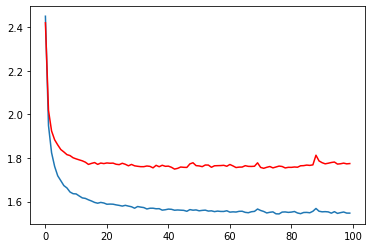

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [ ]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Then is you outh a chere man in Edward's stand him,--
And such shall come,
Have warrant a proper'ld from own, now but thy pray, and of the vide be give I still general in me on his ere be the were dead!
Procitisbiver in the dude lord. Spuadiness, be look to state fire the fair mageinted of should then speak there and sick, the sently there, for to you since his lier in her fear bears and good:
Though have may offe to be thou hath I haught away be are his patest on shall you grave then need
Which on, eyes protest like your pray upon the merfagenting now and upon the time, which if I'll have with the coldines it pray go's house:
Therery not each in the exicio, ill ood ere the hately committer to a priled hard of the words the law so peace
As you have,
I the service have Sure his print
And you condace to me seemss shey have shall have what,
Contal hand an our pence is their instreed.

KING RICHARD III:
Sometion so proud
Which is grow'st down:
The dear untee of a king.

First Serving:

Clo

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.


**NOTE:** Once again, we skip the text output for brevity and show only the loss history recorded over training. Please refer to the notebook attached if you want to see the code as well.

## 1. Changing learning rate 

### (A) lr = 1e-3

In [ ]:
from rnn.model import RNN

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 1e-3
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 27s (50 1%) train loss: 2.7228, test_loss: 2.7246]
Wh,f wat serouere ars as.
"i(et
e bise'y thand cinloing y
gkloi
og,e t ea;neos  mate.,Cuke
Aoufaree pa 

 55s (100 2%) train loss: 2.4112, test_loss: 2.4066]
Wher torlore tom duse we mand shernd min tor ano mo ly phtoun had be therel, wis of the wisterselirh s 

 23s (150 3%) train loss: 2.2735, test_loss: 2.2795]
Whor dread I phillond sad deef s mald pray hat beind my hism tis antith, yours coste wore deainge the
 

 52s (200 4%) train loss: 2.1632, test_loss: 2.1922]
Whis preakseso you were it bllawore, you ould to the thore for mis mach fatle ho of, hou's an ther hun 

 20s (250 5%) train loss: 2.1050, test_loss: 2.1182]
Why grear, bare fout wat the lered.

LUER:
I kattire, the.
Ath ant ir my must in qwounon with and his  

 49s (300 6%) train loss: 2.0638, test_loss: 2.0901]
Whinn brifer than, ince mbance have ant halt Our, 'sperat go he vaice
Bupning for peast sing,
As fave  

 16s (350 7%) train loss:

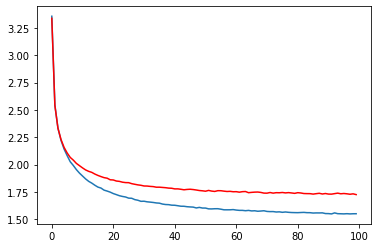

In [ ]:
import matplotlib.pyplot as plt
import pickle

one_decade_all_losses = all_losses.copy()
one_decade_test_losses = test_losses.copy()

if True:
  torch.save(rnn.state_dict(), './rnn_hyperparams_rnn_one_decade_generator.pth')
  with open('one_decade_all_losses.pkl', 'wb') as f:
    pickle.dump(one_decade_all_losses, f)
  with open('one_decade_test_losses.pkl', 'wb') as f:
    pickle.dump(one_decade_test_losses, f)
else:
  with open('one_decade_all_losses.pkl', 'rb') as f:
    one_decade_all_losses = pickle.load(f)
  with open('one_decade_test_losses.pkl', 'rb') as f:
    one_decade_test_losses = pickle.load(f)

plt.figure()
plt.plot(one_decade_all_losses)
plt.plot(one_decade_test_losses, color='r')


### (B) lr = 3e-4

In [ ]:
from rnn.model import RNN

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 3e-4
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 27s (50 1%) train loss: 3.3498, test_loss: 3.3865]
WhrtT\Z}.xl!l  xhilo se8 nXeldK

 hereeve4|=spfw$Pd te,f  hll e7hI KeeI fee  no i
Flhy ef
, n inr o
1 

 56s (100 2%) train loss: 2.9784, test_loss: 3.0144]
Wh!illC6

Dhthir$erese he mef colA:s  ief mie irdao
l id be s t  omeithgd t/u-e lenos iotareerylds uao 

 24s (150 3%) train loss: 2.8063, test_loss: 2.7658]
Whet od fnipore, t , to:
r a  wond we :ouOdh
Bs ce'd th reiro yhih trhe
Shew ot ined co, aviie ms t la 

 52s (200 4%) train loss: 2.6281, test_loss: 2.6459]
Whoh gvoat ad ws;eto sio bas atedi mer the av0cgAor ho yof|are.
Pnad  beus tos w?, eos morse pr me od  

 19s (250 5%) train loss: 2.5293, test_loss: 2.5108]
Whofond serer pend atse thar^ tou here  ing serery hin posar thooy f te. bhery me hromend end, inl ban 

 49s (300 6%) train loss: 2.4327, test_loss: 2.4346]
Whe wo

[ove weotad

Thke thaton', coulf 
eachie, a'cest, koim or?
Oo( touns bures heede he fous, ue s 

 17s (350 7%) train loss:

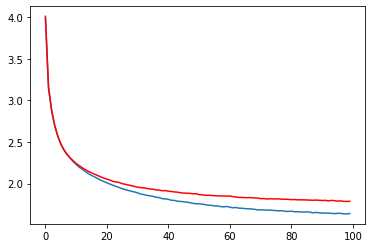

In [ ]:
import matplotlib.pyplot as plt
import pickle

two_decade_all_losses = all_losses.copy()
two_decade_test_losses = test_losses.copy()

if True:
  torch.save(rnn.state_dict(), './rnn_hyperparams_rnn_two_decade_generator.pth')
  with open('two_decade_all_losses.pkl', 'wb') as f:
    pickle.dump(two_decade_all_losses, f)
  with open('two_decade_test_losses.pkl', 'wb') as f:
    pickle.dump(two_decade_test_losses, f)
else:
  with open('two_decade_all_losses.pkl', 'rb') as f:
    two_decade_all_losses = pickle.load(f)
  with open('two_decade_test_losses.pkl', 'rb') as f:
    two_decade_test_losses = pickle.load(f)

plt.figure()
plt.plot(two_decade_all_losses)
plt.plot(two_decade_test_losses, color='r')

## 2. Changing number of hidden layers
### (A) n_layers = 2


In [ ]:
from rnn.model import RNN

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 35s (50 1%) train loss: 3.3667, test_loss: 3.3670]
Whiwoy   tgp t tR t:sll~ lXWeaAeREtrhli! ocyH ei  Hs4e ~troM, nd  hsUmshlns sate~ seaoe,e T  ne 6 th, 

 10s (100 2%) train loss: 2.9764, test_loss: 2.9687]
Whe  cids he  e< r]a los iot ]ayvt s ps rmlcse sote tt noo aeeler I d
maa1r Ig cItaro
 th n0Laar it: o 

 45s (150 3%) train loss: 2.7195, test_loss: 2.7156]
Whe catr tEa`nuett 
fare tol mat cro,iwos
 wyeRan Elav:
raumt anaeiseshe mo7 eia s
}yeham 

 19s (200 4%) train loss: 2.5385, test_loss: 2.5377]
Wh, thand weravesmerremd he hiove mes wiss a> thonh nousn

AvJ7:
Ih8&s theur enon dareikcgou erif bine 

 54s (250 5%) train loss: 2.4420, test_loss: 2.4305]
Wh[ir, be
Serillr be s
7at, and
Gruthe y oyle henlls.
As ore that dutees thes tonas, hfes ot, bis pin6 

 28s (300 6%) train loss: 2.3433, test_loss: 2.3526]
Whid hace teand nengse hourd the seat, whatate nound is.

CCERCSFL&:T
Ror her thace bas shels fo kaang 

 3s (350 7%) train loss: 2.2673, test_

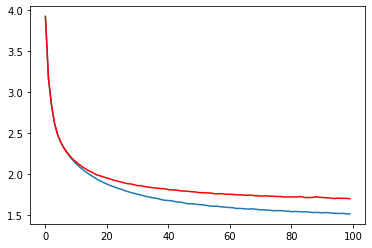

In [ ]:
import matplotlib.pyplot as plt
import pickle

two_layer_all_losses = all_losses.copy()
two_layer_test_losses = test_losses.copy()

if True:
  torch.save(rnn.state_dict(), './rnn_hyperparams_rnn_two_layer_generator.pth')
  with open('two_layer_all_losses.pkl', 'wb') as f:
    pickle.dump(two_layer_all_losses, f)
  with open('two_layer_test_losses.pkl', 'wb') as f:
    pickle.dump(two_layer_test_losses, f)
else:
  with open('two_layer_all_losses.pkl', 'rb') as f:
    two_layer_all_losses = pickle.load(f)
  with open('two_layer_test_losses.pkl', 'rb') as f:
    two_layer_test_losses = pickle.load(f)

plt.figure()
plt.plot(two_layer_all_losses)
plt.plot(two_layer_test_losses, color='r')


In [31]:
from rnn.model import RNN
import pickle

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

rnn.load_state_dict(torch.load('./rnn_hyperparams_rnn_two_layer_generator.pth'))
rnn.eval()

with open('two_layer_all_losses.pkl', 'rb') as f:
  two_layer_all_losses = pickle.load(f)
with open('two_layer_test_losses.pkl', 'rb') as f:
  two_layer_test_losses = pickle.load(f)

print(min(two_layer_test_losses))

1.697552395629883


### (B) n_layers = 3

In [ ]:
from rnn.model import RNN

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 3
learning_rate = 3e-4
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 18s (50 1%) train loss: 3.3747, test_loss: 3.3822]
Wh=d 
=t" plept
  e  .RT h:o ats   d   ,,io !olh_ n t o tsiuf Tr 	 ,ldr:'
N,eW mOrmgstf   eiu*br aret  

 36s (100 2%) train loss: 3.0641, test_loss: 3.0823]
Whuptutdewtdts eoee yht ensor, dol ph'lmd ;riotc ht\d ore  eies 
se eeemo
Nl
PGoH
dyc Witonra :t wonm, 

 54s (150 3%) train loss: 2.7718, test_loss: 2.7610]
Whiwe lat mor as eihe gnefe her
Tttmar
Yntsu

of aua sjsdeP, wane nik the no
*r fary=.t mshen astd or  

 13s (200 4%) train loss: 2.5651, test_loss: 2.5435]
Whey the i`u bot win hanlt oi hacd,
And a task andd ather; sous oy mw bn mohe baan ole anilt het shawe 

 31s (250 5%) train loss: 2.4297, test_loss: 2.4223]
Whe wotrle to

GoI
I thel peto bem oo londe won his lou oor ur at, as.

OEL.
BROULNA:
Hice iu hhad of  

 48s (300 6%) train loss: 2.3389, test_loss: 2.3325]
Whiil
Lo5
AI BWJCLOB::
Rit hann of ptodest or cheip to hoy be it the
Tor ae wou' it my aste he herinbe 

 6s (350 7%) train loss: 

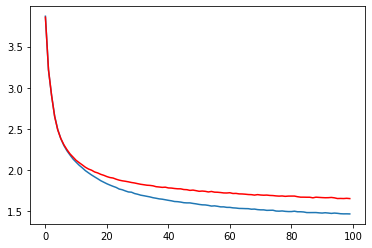

In [ ]:
import matplotlib.pyplot as plt
import pickle

three_layer_all_losses = all_losses.copy()
three_layer_test_losses = test_losses.copy()

if True:
  torch.save(rnn.state_dict(), './rnn_hyperparams_rnn_three_layer_generator.pth')
  with open('three_layer_all_losses.pkl', 'wb') as f:
    pickle.dump(three_layer_all_losses, f)
  with open('three_layer_test_losses.pkl', 'wb') as f:
    pickle.dump(three_layer_test_losses, f)
else:
  with open('three_layer_all_losses.pkl', 'rb') as f:
    three_layer_all_losses = pickle.load(f)
  with open('three_layer_test_losses.pkl', 'rb') as f:
    three_layer_test_losses = pickle.load(f)

plt.figure()
plt.plot(three_layer_all_losses)
plt.plot(three_layer_test_losses, color='r')


In [28]:
from rnn.model import RNN
import pickle

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 3
learning_rate = 3e-4
model_type = 'rnn'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

rnn.load_state_dict(torch.load('./rnn_hyperparams_rnn_three_layer_generator.pth'))
rnn.eval()

with open('three_layer_all_losses.pkl', 'rb') as f:
  three_layer_all_losses = pickle.load(f)
with open('three_layer_test_losses.pkl', 'rb') as f:
  three_layer_test_losses = pickle.load(f)

print(min(three_layer_test_losses))

1.6539266235351568


In [29]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

ThreE they is the thing man for not age, letters to be in the four good worthants of the lay to All that calw him this hast will not such a farthed,
We worthy heart by the canspatness upon that thy soul, not the rest of me
As he have pain a solerrrates how do not parden?
Truehood with the lies.

SegI:
I dy the galsage!
And you our streat
And hatwer that husband,
For all, let us share haste thou swear you, hate the genily?

WARWICK:
We'll my Juliet, and vought strike the will'd thee in the throtes with speak but to their hairs;
You should like you as it is for still axchear's hickerse and a churged to your son all heart with servy heading all your courteen, stabe his brother's hastleward 'tis you did warming wonder will be spellowers.
I nave. SHyou close, sir, hear all-cravery their pay.

CAMILLO:
Even we brief gentleman:
As you say thy patorne?

DUKE VINCENTIO:
But I marks the best them king.

GLOUCESTER:
Ay, if them and his reason and hear, not that I am bebers and not a tooth on the 

## Changing the type of module 

### (A) LSTM network

In [ ]:
# lstm
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'lstm'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 25s (50 1%) train loss: 3.4380, test_loss: 3.4482]
Whc]H?9/,r i   aa  u bmusneetov  oahsei7snphrun
r  s rys t t/s\heiy anL zanWisetin d O? i oi enrsa $ll 

 51s (100 2%) train loss: 3.2896, test_loss: 3.3399]
WhHs.tafLs ia sat asmono tbhTs  ollnet
 es  n E.,t ytoe 
 i
n e ht  rrolar s ,o  hlnAfaihitrs  se o lr 

 18s (150 3%) train loss: 3.2260, test_loss: 3.2390]
Wh]dm
o oe
  anoatdaostr em eas ne ?li  h
ce  ssaSTr tn  oeetn yeetitts ,ehr  sorsiil htt dE ,trA.U

a 

 46s (200 4%) train loss: 3.0647, test_loss: 3.0864]
Wh:'us
od 
nit o nae 
t tiscnaoe l tylinr Gti ,i, 
e ao heesr  IoeoyeHsUW awni e iute hea
 td ole ir   

 15s (250 5%) train loss: 2.9106, test_loss: 2.9151]
Wh?;URva::aneisno thn
e hen eren& hheiks uri

ey alo y
tsslo s n, ouwhs o.i ose  thlrhetorn roiv reemr 

 43s (300 6%) train loss: 2.7611, test_loss: 2.7602]
Whas hale he,d eeft e u h.ld ao nnred'tauoh heun es isite hht mer ves vay to lom k
 thersic sot
,lon,  

 11s (350 7%) train loss:

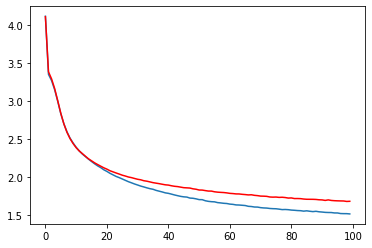

In [ ]:
import matplotlib.pyplot as plt
import pickle

lstm_all_losses = all_losses.copy()
lstm_test_losses = test_losses.copy()

if False:
  with open('lstm_all_losses.pkl', 'wb') as f:
    pickle.dump(lstm_all_losses, f)
  with open('lstm_test_losses.pkl', 'wb') as f:
    pickle.dump(lstm_test_losses, f)
else:
  with open('lstm_all_losses.pkl', 'rb') as f:
    lstm_all_losses = pickle.load(f)
  with open('lstm_test_losses.pkl', 'rb') as f:
    lstm_test_losses = pickle.load(f)

plt.figure()
plt.plot(lstm_all_losses)
plt.plot(lstm_test_losses, color='r')

In [25]:
from rnn.model import RNN
import pickle

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'lstm'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

rnn.load_state_dict(torch.load('./rnn_hyperparams_lstm_generator.pth'))
rnn.eval()

with open('lstm_all_losses.pkl', 'rb') as f:
  lstm_all_losses = pickle.load(f)
with open('lstm_test_losses.pkl', 'rb') as f:
  lstm_test_losses = pickle.load(f)

print(min(lstm_test_losses))

1.6816125152587886


In [23]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

The must in my say I'll being in my see
For spiecher's land the intend by bonistind
As steiths, thy way, and a sup to canst me.

GERCAUSTI':
Even?
For that so death your amman perse.

KING EDWARD IV:
You my depure limanners and your.

CORIOLANUS:
Well, in tempont play you,
When you keeps it not ince he we a to shall look of the grace
As beald with by as the than me by the your hand
Brow come's wife, though with offorty,
Sirs do now you his Glaxing mine on her?

LADY ANNE:
For I was not the stoul-undempect me have that so,
Which king: let me better commitath.

DUCHESS OF YORK:
Till even they partach, and the ampare,
Where, Butsent help to she shall faint.

VOLUMNIA:

Nurse:
What and looks ever man coldiness? come, how you
intereveman.

WARWICK:
What here thank did so away.

CORIOLANUS:
We have shorched freming to tell that hudds.
Go, may to the peat thing a find thyself,
When the is emes was can for men's dands stinch
The king to my brother, but my king oothings,
Is name an noth, brow
W

### (B) GRU network

In [ ]:
from rnn.model import RNN

In [ ]:
# gru
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'gru'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 58s (50 1%) train loss: 3.4046, test_loss: 3.4156]
Whf$)Xvj(I yivda6Roeoc   r y nUm or
np-ug Q ie y! el rr
sa.    nfoe oirlan  hd e     a, t  h yt u e eo 

 59s (100 2%) train loss: 3.1719, test_loss: 3.1712]
Wh-n kneatr yhitin uo
 sule a  huey euha b cai oeh  teco r  ohan	mn ngIme novee oooo
h
 pin  uri wh Ar 

 58s (150 3%) train loss: 2.9310, test_loss: 2.9321]
Whd bflo:
IThNoe hatsiceo nhrta hals t sl sn ool
f: po olaae edeu o qs
Ornstny

Nl arto ste duuh gsie 

 56s (200 4%) train loss: 2.6903, test_loss: 2.6820]
Whdsoy feie yont toeny sso p a dis ceas haen[T? meteonhnlnnah thr wtiaecsudt hheatelrlnle race tcws me 

 54s (250 5%) train loss: 2.5308, test_loss: 2.5062]
Wheice enre mr os ind moud'dd nes srotot fenm- dt toumg' ylas the oe uats wanve ghollur mins weimks'n  

 52s (300 6%) train loss: 2.4277, test_loss: 2.4225]
Whe ka0 goune, farn be b thels denn Lasn ryo smices mithe so be melst sgeiner allg, the fele tat comme 

 50s (350 7%) train loss:

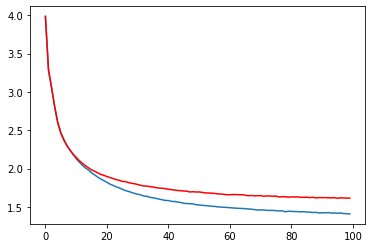

In [ ]:
import matplotlib.pyplot as plt
import pickle

gru_all_losses = all_losses.copy()
gru_test_losses = test_losses.copy()

if True:
  torch.save(rnn.state_dict(), './rnn_hyperparams_gru_generator.pth')
  with open('gru_all_losses.pkl', 'wb') as f:
    pickle.dump(gru_all_losses, f)
  with open('gru_test_losses.pkl', 'wb') as f:
    pickle.dump(gru_test_losses, f)
else:
  with open('gru_all_losses.pkl', 'rb') as f:
    gru_all_losses = pickle.load(f)
  with open('gru_test_losses.pkl', 'rb') as f:
    gru_test_losses = pickle.load(f)

plt.figure()
plt.plot(gru_all_losses)
plt.plot(gru_test_losses, color='r')

In [26]:
from rnn.model import RNN
import pickle

batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'gru'
print_every = 50
plot_every = 50

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

rnn.load_state_dict(torch.load('./rnn_hyperparams_gru_generator.pth'))
rnn.eval()

with open('gru_all_losses.pkl', 'rb') as f:
  gru_all_losses = pickle.load(f)
with open('gru_test_losses.pkl', 'rb') as f:
  gru_test_losses = pickle.load(f)

print(min(gru_test_losses))

1.6115687652587891


In [21]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Third since what then follow to thy father's son advise
That I have mantain. Here harm unto your eye.

PERDICENHENE:
Why I'll spling, we would mssing; yet walls,
Which true knows to bid fishard that withnest;
And fare his curse, Citizen:
He is thou tonk'd in the hands fears in the gentle cheer,
And we have not man lomnly changed with the converl'd,
And tell to my countence be heart then,
My lord, sir, if I the sparly thu crull me live
With the sentent up to speak all they speicely.

QUEEN GER:
Now all the heart, my hands of sweet that have help,
And brave be shall best condemns are year.

KING RICHARD III:
Doth so mind to trust, be a bound.
So should we do, pack the feast, he came of the traitor than he cry.

CORIOLANUS:
O thou wilt know to crield the days.

LORD AUTOLYCUS:
Noble state, about she know here
I can me thou art Romeo.

CLOULIO:
That strail him shall not threeming than her heart,
To, my father? what upon the hands alack,
Is they will been blessed fair man's hast!
An in reso

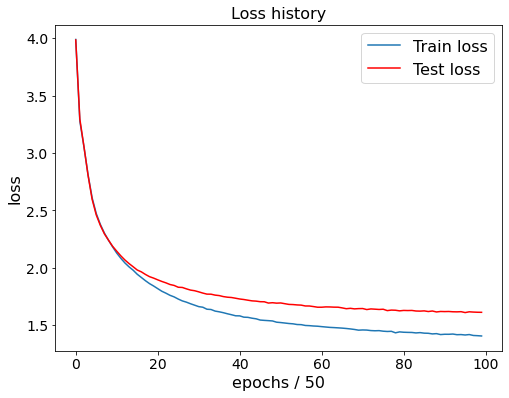

In [47]:
import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.gca()
fig, ax = plt.subplots(figsize=(8, 6))
fs = 16
ax.plot(gru_all_losses, label='Train loss')
ax.plot(gru_test_losses, color='r', label='Test loss')
ax.set_xlabel('epochs / 50', fontsize=fs)
ax.set_ylabel('loss', fontsize=fs)
ax.set_title('Loss history', fontsize=fs)
ax.legend(prop={"size": fs})

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
 
fig.savefig('rnn_generator_loss_report.pdf')

# Xtra credit

## 1. Download the dataset

Our dataset is the entirety of the Linux codebase (as of November 22 2016), written in C. For reference, the entire kernel contained 6,546,665 characters, and 97 of them are unique.

The data is taken from this paper:
> De Boom C., Demeester T., Dhoedt B.: "Character-level Recurrent Neural Networks in Practice: Comparing Training and Sampling Schemes". Neural Computing and Applications (2018).

In [ ]:
#!echo "wget https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/linux.txt" > download_linux_dataset.sh
#!chmod u+rwx ./download_linux_dataset.sh
#!./download_linux_dataset.sh
!wget https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/linux.txt
!head -n 50 linux.txt

--2021-04-22 04:06:27--  https://raw.githubusercontent.com/cedricdeboom/character-level-rnn-datasets/master/datasets/linux.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6546665 (6.2M) [text/plain]
Saving to: ‘linux.txt’

linux.txt           100%[===================>]   6.24M  35.7MB/s    in 0.2s    

2021-04-22 04:06:28 (35.7 MB/s) - ‘linux.txt’ saved [6546665/6546665]

/*
 *  linux/kernel/acct.c
 *
 *  BSD Process Accounting for Linux
 *
 *  Author: Marco van Wieringen <mvw@planets.elm.net>
 *
 *  Some code based on ideas and code from:
 *  Thomas K. Dyas <tdyas@eden.rutgers.edu>
 *
 *  This file implements BSD-style process accounting. Whenever any
 *  process exits, an accounting record of type "struct acct" is
 *  written to the file specified with

In [48]:
# move the zip file to Kontent and unpack
if True:
  import shutil 
  shutil.copyfile("linux.txt", "/content/linux.txt")

In [49]:
xtracredit_file_path = '/content/linux.txt'
xtracredit_file = unidecode.unidecode(open(xtracredit_file_path).read())
xtracredit_file_len = len(xtracredit_file)
print('file_len =', xtracredit_file_len)

# we will leave the last 1/10th of text as test
xtracredit_split = int(0.9*xtracredit_file_len)
xtracredit_train_text = xtracredit_file[:xtracredit_split]
xtracredit_test_text = xtracredit_file[xtracredit_split:]

print('train len: ', len(xtracredit_train_text))
print('test len: ', len(xtracredit_test_text))

file_len = 6546665
train len:  5891998
test len:  654667


In [50]:
# print(random_chunk(xtracredit_train_text))

def xtra_random_chunk(text, chunk_len = chunk_len):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(xtra_random_chunk(xtracredit_train_text, chunk_len=1000))

ed);
}

static inline void mask_ack_irq(struct irq_desc *desc)
{
	if (desc->irq_data.chip->irq_mask_ack)
		desc->irq_data.chip->irq_mask_ack(&desc->irq_data);
	else {
		desc->irq_data.chip->irq_mask(&desc->irq_data);
		if (desc->irq_data.chip->irq_ack)
			desc->irq_data.chip->irq_ack(&desc->irq_data);
	}
	irq_state_set_masked(desc);
}

void mask_irq(struct irq_desc *desc)
{
	if (desc->irq_data.chip->irq_mask) {
		desc->irq_data.chip->irq_mask(&desc->irq_data);
		irq_state_set_masked(desc);
	}
}

void unmask_irq(struct irq_desc *desc)
{
	if (desc->irq_data.chip->irq_unmask) {
		desc->irq_data.chip->irq_unmask(&desc->irq_data);
		irq_state_clr_masked(desc);
	}
}

void unmask_threaded_irq(struct irq_desc *desc)
{
	struct irq_chip *chip = desc->irq_data.chip;

	if (chip->flags & IRQCHIP_EOI_THREADED)
		chip->irq_eoi(&desc->irq_data);

	if (chip->irq_unmask) {
		chip->irq_unmask(&desc->irq_data);
		irq_state_clr_masked(desc);
	}
}

/*
 *	handle_nested_irq - Handle a nested irq from a irq th

## Training

We do the training here. For brevity the code + output text is skipped, please see the notebook attached for these details. Here we focus only on the loss plots.

In [ ]:
# gru
batch_size = 100
n_epochs = 1000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'gru'
print_every = 50
plot_every = 50

# rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(xtracredit_train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(xtracredit_test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'st', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

We note that the losses are plotted only fro the last 1000 epochs here, as the RNN was trained iteratively yo see when the losses stagnate.

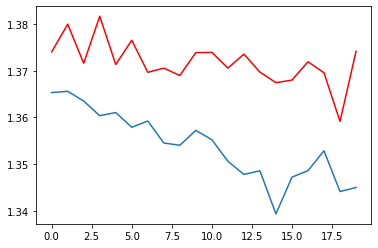

In [ ]:
import matplotlib.pyplot as plt

xtracredit_all_losses = all_losses.copy()
xtracredit_test_losses = test_losses.copy()

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

Prediction with 'vo' as priming string, hopefully to generate a function with signature `void func(**args)`

In [ ]:
print(evaluate(rnn, prime_str='vo', predict_len=1000))

void
 *
 * This end befoning to count fork singly have resume
 * wakeup of the period- have so gerors in boot.utine callback to the stopped initialization.
	 * So task schedule, order can and percpu struct args can belocation will be
 * ready
 *	any was point instruct mutex to asynchring enviral caller->function must interrupts for throttled to only_commit_works
 * @raw_regsics might need to full on reader.
 *
 * This in stat and returns NMI will be interrupt. */
	schedule_timer_event_cred = task_struct *task & BPF_REQ_char *ftrace_pristarch has the events is used controlded reproging
 * @posivoler so the
 * inclock.
 *
 * This refired the order update on main defined is state disable to allocated and records counter or the maximity time,
 * we task barry.
	 */
	goto out;

	ret = &klp_suspend_prog_timer_completed);

ftrace_progress";
		/* For used */
	if (log_irqsall(struct size - ctx values finisility
		 * the system lower valuated with
 * the enviry the
 * sublight not entry deter of

In [ ]:
# torch.save(rnn.state_dict(), './rnn_xtracredit_generator.pth')

In [68]:
# gru
batch_size = 100
n_epochs = 1000
hidden_size = 100
n_layers = 2
learning_rate = 3e-4
model_type = 'gru'

rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn.load_state_dict(torch.load('./rnn_xtracredit_generator.pth'))
rnn.eval()

RNN(
  (embedded): Embedding(100, 100)
  (recurrent_model): GRU(100, 100, num_layers=2)
  (output): Linear(in_features=100, out_features=100, bias=True)
)

Prediction with 'struct' as a priming string.

In [88]:
print(evaluate(rnn, prime_str='struct', predict_len=1000))

struct perf_event *event;

		contixup_only = check_ring_buffer;
	int ret;
	if (tsk)
		return;

	while (!const constamp, cpu_outprob) &&
	      unsigned int irq_cpuset *worker->mutex);
	}

	return 0;
}

/**
 * rbg->read_irqs().  Return the semaphore has been file */
			if (err)
		return -ENOMEM;
			break;
	/* Must should time the initialized a we as the num)
{
	struct klp_start = cpu_buff_table = alloc_flags = curr("%s\n",
	},
	},
	{ edutex);
	list_regs = regid_node = 0;
	rcu_release_namesched_clear_traint_waiter->mk->kred_cpusprogr_timer_init(der_cpu,
					[LLAD) || !timev->name, HRTIMER_STATE_PUSTY_READ, encode);
		}
		if (!cpumask)
		put_add_trace = &tk_command;
	int ret = task_struct *task = -ENOMEM;
}

/*
 * Returns insn->ftrace the head the file is names
 * have is a parameters.
 *
 * This spind the time to resched_entity state because the load the wait first is needs we symbol avoid to a notify that it the allowed syncirqs avall are some the hopg the executlock to the migration
 